<a href="https://colab.research.google.com/github/Randyliao/Data_science_practice/blob/master/Deep_Learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

!apt-get install graphviz -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
import os
from torchvision import models
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score
from torch import optim, cuda

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!unzip -uq "/content/drive/My Drive/MMAI Deep learning/thecarconnectionpicturedataset.zip" -d "/content/drive/My Drive/MMAI Deep learning/image"

In [0]:
#!ls

In [3]:
%cd/content/drive/My Drive/MMAI Deep learning/image/thecarconnectionpicturedataset

/content/drive/My Drive/MMAI Deep learning/image/thecarconnectionpicturedataset


y

In [4]:
cars = glob("*.jpg")
cars = np.random.permutation(cars)
audi=[i for i in cars if i.split('_')[0] in 'Audi']
BMW =[i for i in cars if i.split('_')[0] in 'BMW']
print(f'there are {len(audi)} audi and {len(BMW)} BMW totally')
print(f'there are total {len(cars)} cars')

there are 3131 audi and 4121 BMW totally
there are total 7252 cars


In [5]:
n_each = np.minimum(len(audi), len(BMW))//1000*1000
cars= np.random.choice(audi,n_each,replace=False).tolist()+np.random.choice\
      (BMW,n_each,replace=False).tolist()
cars

makes=np.repeat('audi',n_each).tolist()+np.repeat('bmw',n_each).tolist()


assert(len(cars)==len(makes))

print(f'the total number of sample size is {len(cars)}')

the total number of sample size is 6000


In [6]:
##load images
train_img=[]
for img_name in tqdm(cars):
    img=imread(img_name)
# normalizing the pixel values
    img = img/255
# resizing the image to (224,224,3)
    img = resize(img, output_shape=(224,224,3), mode='constant', anti_aliasing=True)
# converting the type of pixel to float 32
    img = img.astype('float32')
# appending the image into the list
    train_img.append(img)

100%|██████████| 6000/6000 [33:56<00:00,  2.66it/s]


In [7]:
# converting the list to numpy array
x = np.array(train_img)
x.shape

(6000, 224, 224, 3)

It is an audi vehicle


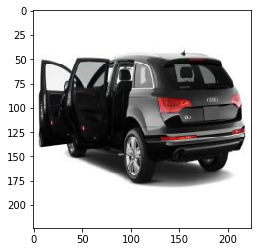

In [8]:
# Exploring the data
index = 10
plt.imshow(x[index])
if (makes[index] == 'audi'):
    print('It is an audi vehicle')
else:
    print('It is a bmw vehicle')

In [9]:
# defining the target
y = np.array(makes)
le = LabelEncoder()
y= le.fit_transform(y)
y.shape


(6000,)

In [27]:
# create test and test datset
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.3, random_state = 42)
(train_x.shape, train_y.shape), (test_x.shape, test_y.shape)

(((4200, 224, 224, 3), (4200,)), ((1800, 224, 224, 3), (1800,)))

In [29]:
# converting training images into torch format
train_x = train_x.reshape(4200, 3, 224, 224)
train_x  = torch.from_numpy(train_x)
# converting the target into torch format
train_y = train_y.astype(int)
train_y = torch.from_numpy(train_y)
# shape of training data
train_x.shape, train_y.shape

(torch.Size([4200, 3, 224, 224]), torch.Size([4200]))

In [30]:
# converting test images into torch format
test_x = test_x.reshape(1800, 3, 224, 224)
test_x  = torch.from_numpy(test_x)
# converting the target into torch format
test_y = test_y.astype(int)
test_y = torch.from_numpy(test_y)
# shape of test data
test_x.shape, test_y.shape

(torch.Size([1800, 3, 224, 224]), torch.Size([1800]))

In [32]:
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
# Freeze model weights
for parameter in model.parameters():
    parameter.requires_grad = False

In [0]:
#add on classifier
model.fc = Sequential(Linear(512, 2), Dropout(0.2))
for parameter in model.fc.parameters():
    parameter.requires_grad = True

In [0]:
# checking if GPU is available if yes, then running on gpu
if torch.cuda.is_available():
    model = model.cuda()

In [36]:
torch.cuda.is_available()

True

In [0]:
class CarTrain():
    
    def __init__(self):
        self.len = train_x.shape[0]
        self.train_x = train_x
        self.train_y = y_train
        
    def __getitem__(self, index):
        return train_x[index], train_y[index] 
    
    def __len__(self):
        return self.len

In [0]:
class CarTest():
    
    def __init__(self):
        self.len = test_x.shape[0]
        self.test_x = test_x
        self.test_y = test_y
        
    def __getitem__(self, index):
        return test_x[index], test_y[index] 
    
    def __len__(self):
        return self.len

In [0]:
#Making data iterator
train = CarTrain()
test = CarTest()
train_loader = DataLoader(dataset=train, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=128, shuffle=True)

In [65]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [72]:
trainiter

batch_size, which can be used to save memory and improve running efficiency
one batch is a sample of the full training data, one iterstion is the foward and backward of one batch
one epoch is the one time of running the full training data
if training data size is 1000, batch is 500, then there are 2 times of iterations,
and it will take 2 iterations to complete 1 epoch.

In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
loss_function = CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate
# gradient descent on the layer that we customized in transfer learning
optimizer = optim.Adam(model.parameters(), lr=0.0005)

#train model
# batch size
batch_size = 128

# number of epochs to train the model
n_epochs = 50

In [82]:
epochs = 100
steps = 0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    model.train()
    for images, labels in train_loader:   
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()     
        optimizer.zero_grad()
        log_ps = model(images)
        loss = loss_function(log_ps, labels)
        loss.backward()
        optimizer.step()        
        running_loss += loss.item()        
    else:
        test_loss = 0
        accuracy = 0        
        model.eval()
        with torch.no_grad():
            for images, labels in test_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()
                log_ps = model(images)
                test_loss += loss_function(log_ps, labels)                
                # ps = torch.exp(log_ps)
                top_p, top_class = log_ps.topk(1, dim=1)
                equals = top_class.long() == labels.long().view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))                
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))
        print("[Epoch: {}/{}] ".format(e+1, epochs),
              "[Training Loss: {:.3f}] ".format(running_loss/len(train_loader)),
              "[Test Loss: {:.3f}] ".format(test_loss/len(test_loader)),
              "[Test Accuracy: {:.3f}]".format(accuracy/len(test_loader)))

[Epoch: 1/100]  [Training Loss: 0.703]  [Test Loss: 0.683]  [Test Accuracy: 0.558]
[Epoch: 2/100]  [Training Loss: 0.693]  [Test Loss: 0.675]  [Test Accuracy: 0.590]
[Epoch: 3/100]  [Training Loss: 0.677]  [Test Loss: 0.672]  [Test Accuracy: 0.592]
[Epoch: 4/100]  [Training Loss: 0.671]  [Test Loss: 0.674]  [Test Accuracy: 0.582]
[Epoch: 5/100]  [Training Loss: 0.663]  [Test Loss: 0.654]  [Test Accuracy: 0.630]
[Epoch: 6/100]  [Training Loss: 0.663]  [Test Loss: 0.659]  [Test Accuracy: 0.611]
[Epoch: 7/100]  [Training Loss: 0.657]  [Test Loss: 0.660]  [Test Accuracy: 0.617]
[Epoch: 8/100]  [Training Loss: 0.652]  [Test Loss: 0.651]  [Test Accuracy: 0.639]
[Epoch: 9/100]  [Training Loss: 0.654]  [Test Loss: 0.675]  [Test Accuracy: 0.592]
[Epoch: 10/100]  [Training Loss: 0.656]  [Test Loss: 0.654]  [Test Accuracy: 0.624]
[Epoch: 11/100]  [Training Loss: 0.647]  [Test Loss: 0.665]  [Test Accuracy: 0.618]
[Epoch: 12/100]  [Training Loss: 0.642]  [Test Loss: 0.654]  [Test Accuracy: 0.622]
[

In [89]:
print('test accuracy: \t', np.average(accuracy)/len(test_loader))

test accuracy: 	 0.6348958333333333
